In [3]:
import glob
import pandas as pd
#import random
#import paho.mqtt.client as mqtt
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import statistics #Group B - find mean
from scipy.constants import c, m_p, e

In [4]:
files = glob.glob(r"C:\Users\ilw61967\Desktop\BLM_R5IM_Data\cycle" + '/*.csv')

In [5]:
selected_file = files[5]
input_data = pd.read_csv(selected_file)
array = input_data.drop(columns = input_data.columns[0]).to_numpy()

In [6]:
from copy import deepcopy

import numpy as np


class DataFilter:
  '''A object with configurable settings to filter input data.
  '''

  labels = ["r0blm1", "r0blm3", "r0blm4",
            "r1blm1", "r1blm2", "r1blm3", "r1blm4",
            "r2blm1", "r2blm2", "r2blm3", "r2blm4",
            "r3blm1", "r3blm2", "r3blm3", "r3blm4",
            "r4blm1", "r4blm2", "r4blm3", "r4blm4",
            "r5blm1", "r5blm2", "r5blm3", "r5blm4",
            "r6blm1", "r6blm2", "r6blm3", "r6blm4",
            "r7blm1", "r7blm2", "r7blm3", "r7blm4",
            "r8blm1", "r8blm2", "r8blm3", "r8blm4",
            "r9blm1", "r9blm2", "r9blm3", "r9blm4",
            "r5im"]
  
  
  def __init__(self, *, select = True, invert = False, scale = 1, offset = 0, auto_offset = 0):
    '''Creates a filterer object, with configurable settings to filter input data.
    '''

    self.data = []

    template = {
      "select": select,
      "invert": invert,
      "scale": scale,
      "offset": offset,
      "auto_offset": auto_offset,
    }

    self.settings = [deepcopy(template) for i in range(40)]

  def _index_(self, label) -> int:
    '''A minor inner method to convert the string name of a BLM to its corresponding index.'''

    if isinstance(label, int):
      return label
    elif isinstance(label, str):
      return DataFilter.labels.index(label)
    else:
      raise TypeError

  
  def invert(self, data: np.array) -> np.array:
    out = -data
    return out

  def scale(self, data: np.array, factor: int | float) -> np.array:
    out = data * factor
    return out
  
  def offset(self, data: np.array, *, offset: int | float = 0, points: int = None) -> np.array:
    '''Offsets data by either `offset`, or zeroes it using a given number of data points as reference for the zero-level.'''
    
    out = data

    if isinstance(points, int):
      if points > 0:
        auto_offset = np.mean(data[:points])
      elif points < 0:
        auto_offset = np.mean(data[points:])
      else:
        raise ValueError("Invalid value for number of reference points")
      out = data - auto_offset

    if offset != 0:
      out = data + offset
    
    return out

  
  def set(self, setting: str, state, labels: list[str | int] = None) -> None:
    '''Configures a particular filter `setting` for a number of BLMs.

    `setting`: the filter setting to configure.
    `state`: the value to set the setting to.
    `labels`: the BLMs to apply the setting to.
    '''

    # if none specified, set for all
    if labels is None:
      for each in self.settings:
        each[setting] = state
    
    else:
      # single specified
      if isinstance(labels, str) or isinstance(labels, int):
        self.settings[self._index_(labels)][setting] = state

      # multiple specified
      else:
        for each in labels:
          self.settings[self._index_(each)][setting] = state

  
  def reset(self) -> None:
    '''Resets filters to their default settings.'''

    self.settings = [{
      "select": True,
      "invert": False,
      "scale": 1,
      "offset": 0,
      "auto_offset": 0
    }] * 40

  
  def apply(self, data: np.array) -> np.array:
    '''Filters `data` according to the configured settings.'''
    
    self.data = data
  
    for i, each in enumerate(self.settings):
      # skip if not selected
      if not each["select"]:
        continue

      self.data[i] = data[i]

      if each["invert"]:
        self.data[i] = self.invert(self.data[i])

      if each["scale"] != 1:
        self.data[i] = self.scale(self.data[i], each["scale"])

      if each["offset"] != 0:
        self.data[i] = self.offset(self.data[i], offset = each["offset"])

      if each["auto_offset"] != 0:
        self.data[i] = self.offset(self.data[i], points = each["auto_offset"])

    return [each for i, each in enumerate(self.data) if self.settings[i]["select"]]


In [7]:
def offset_y_data(data, offset = None, n = None, SpecialPoint = None):
    '''Offsets data in y axis by designated value.
    '''

    out = data

    if offset != None:
        out = data + offset
    if SpecialPoint != None:
        out = data - SpecialPoint
        return out

    elif isinstance(n, int):
        if n > 0:
            offset = np.mean(data[:n])
        elif n < 0:
            offset = np.mean(data[n:])
        else:
            raise ValueError("Invalid value for n")
        out = data - offset
    
    return out


In [11]:
def cleanData(array): 
    newArray = []
    filterer = DataFilter()
    filterer.reset
    array = filterer.apply(array)
    filterer.set("invert", True, "r5im")
    array = filterer.apply(array)
    
    for i in array:
        offsetData = offset_y_data(i, SpecialPoint = np.min(i))
        newArray.append(offsetData)
        
    return newArray    

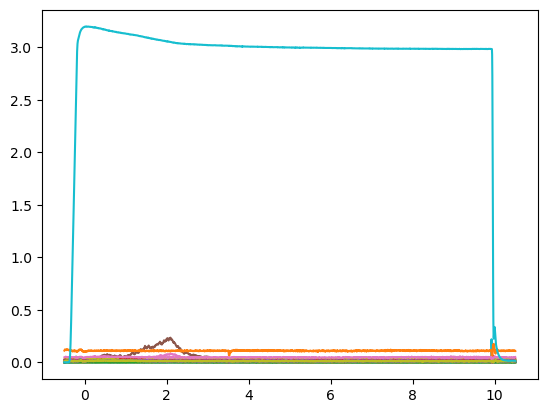

In [15]:
x_data = np.linspace(-0.5,10.5,2200)
for i in cleanData(array):
    plt.plot(x_data, i)

In [14]:
np.shape(cleanData(array))

(40, 2200)